# **Image denoise by Noise2Void 2D**

---

Welcome to run and learn about deep-learning and denoising images! 

Noise2Void 2D is deep-learning method to denoise 2D microscopy images. In this notebook, you caan train your own network and denoise images. The method and original code is based on following article:

**Noise2Void - Learning Denoising from Single Noisy Images**
Alexander Krull, Tim-Oliver Buchholz, Florian Jug
https://arxiv.org/abs/1811.10980

Original notebook of Noise2Void:
https://github.com/juglab/n2v

This notebook and workflow was combined and created by Johanna Jukkala (jjukkala@abo.fi) and supervised by PI Guillaume Jacquemet https://cellmig.org/




# **How to use this notebook?**
---
On the left side you see **Table of contents, Code snippets** and **Files**.

**Table of contents** = contains this table of contents of this notebook. Click the content to move quickly.

**Code snippets** = contain examples how to code certain tasks. You do not need this section to use this notebook.

**Files** = contains all available files. You can **upload** here your files and **connect your Google Drive** (see section 2.3). Remember that all uploaded files will be gone after changing the runtime (see section 2.1) or you exit this notebook. All files saved in Google Drive will remain. Do not use Mount Drive-button; your Google Drive is connected in section 2.3.


"sample data" is default file. Do not upload anything here! 

---
This notebook contain **cells** which can contain ether text or code. 

**Text cell** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

**Coding cell** contains code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appear). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

**If you make any changes to coding cell**, please make a new copy of the notebook into your Google Drive. Right click the gray area below the play button and choose FORM -> SHOW CODE. The code is revealed and can be hided again the same way.

Also, it is advisable to use `#`-mark in cell. Mark allows you to keep the original code piece in cell.
For example:

Original code: all lines are excuted

`my_files = 2`

`my_mask = "names of masks"`

Modified code: the 1st line is not executed, but the 2nd and 3rd line are.

`#my_files = 2`

`my_files = 200`

`my_mask = "names of masks"`

---

#**0. Before getting started**
---
1. Create a following folder tree in your Google Drive:

*   Data
    - test
    - train
      - training_image
      - trained_model
    - results

4. Place all your test images in the **test** folder
3. Place all your training images in the **training_image** folder.
5. **Trained_model** folder will contain files of parameters of trained network. If you have already pretrained network, you can place it here.
7. **Results** - folder will contain denoised images and training values as csv file. Your original images remain in test-folder and unmodified.
---


# **1. Set the Runtime type and mount your Google Drive**



### **1.1. Set the Runtime type**

Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is the programming language in which this notebook is written)*

**Accelator: GPU** *(Graphics processing unit (GPU) accelarates the processing . Without GPU the processing would take much longer)*

---



### **1.2. Mount your Google Drive**


In [0]:
#@markdown Play the cell to Mount your Google Drive.

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **2. Install Network and Dependencies**

### **2.1. Enable Tensorflow 1**

Tensorflow is open-source library, which enables the use of deep-learning programs. 

**What you need to do:** Move your cursor on the `[ ]` mark below. A play-button appear. Click button to start. When operation is ready the animation of play button stops. You can also remove printed details by clicking exit icon below the cell.



In [0]:
#@markdown Play the cell to enable Tensorflow 1.

# enables Tensorflow 1. 
#@markdown * The cell will print the version of Tensoflow 1.
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)
print("Tensorflow enabled.")

1.15.0
Tensorflow enabled.


### **2.2. Install Noise2Void 2D**

Here we install Noise2Void into this notebook. 


In [0]:
#@markdown Play the cell to install Noise2Void 2D.

# instal Noise2Void
!pip install n2v

print("Noise2Void installed.")

     |████████████████████████████████| 61kB 3.7MB/s 
     |████████████████████████████████| 133kB 10.5MB/s 
     |████████████████████████████████| 18.1MB 214kB/s 
Noise2Void installed.


### **2.3 Setup of the notebook**

Here we install all libraries and other depencies to perform the notebook.


In [0]:
#@markdown Play the cell to install libraries.
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible

from pathlib import Path
import os
import pandas as pd
import csv

!pip install memory_profiler
%load_ext memory_profiler
print("Libraries installed")

Using TensorFlow backend.


  Created wheel for memory-profiler: filename=memory_profiler-0.57.0-cp36-none-any.whl size=28992 sha256=1e3a5c67a1743dbbdf959ceabe0c5f21d944f308d25e3d42c84f93e5014b6573
  Stored in directory: /root/.cache/pip/wheels/74/20/b5/20964ef97be73d2c3a695c9cad7bccd96d1e3e737a8163861f
Successfully built memory-profiler
Libraries installed


# **3. Select your parameters and paths**

**What to do:** Enter the following paths and parameters. Copy (right-click) the reguired path from the left from "Files" to form right side of the cell. (looks like: /content/gdrive/Experiment_A1/train/images). **Finally, play the cell to load information to the Noise2Void**. 

**prediction:** 
Enter a path for your images to-be predicted.

**results:** 
Enter a path for your results.

**training:** Enter path of the folder containing your training images. These images remain unmodified and N2V only study them. Use only tif-files!

**modelname** 
Name of you model. Use only my_model -style, not my-model.  If you already have trained networks, enter the name of the pretrained model (the name of the folder which is in trained_model -folder, includes all files of pretrained networks)

**modelpath**: 
Enter path of the folder containing your model to-be-trained or pretrained model. All pretrained and will-be trained models are here (see Section 1). If you already have pretrained networks, enter the path of the pretrained model (the name of the folder in which the my_model is).

**If you use pretrained model, leave the rest of empty. Parameters are uploaded from your model (see above)**

**steps:** 
Input number of steps in each epoch. Original N2V network is trained with 100 steps. 

**epochs:** 
Input how many epochs (rounds) network will be trained. Original N2V network is trained wth 400 epochs. 

**number:**
Input the number of patches per image. The greater number of patches improves the training results but it is also time-consuming.

**size:**
Input the size of patch. Use only number divisible by 4; the model operates only with squares.
Default value is 96 x 96 pixels. Decreasing the patch size improves the training but increases also the training time.

In [0]:
# create DataGenerator-object.
datagen = N2V_DataGenerator()

#@markdown ##Path to predicted images and results:
prediction = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Filopodia_widefield_dataset_low/prediction" #@param {type:"string"}
test_data = prediction
results = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Filopodia_widefield_dataset_low/results" #@param {type:"string"}

#@markdown ##Training the network:
#@markdown Path to training images:
training = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Filopodia_widefield_dataset_low/train" #@param {type:"string"}
training_images = training
imgs = datagen.load_imgs_from_directory(directory = training_images)

#@markdown Name of the model and path to model folder:
name = "N2V_Filopodia_low3_JJ" #@param {type:"string"}
my_model = name
modelpath = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Filopodia_widefield_dataset_low/results" #@param {type:"string"}
path_model = modelpath

#@markdown Number of steps and epochs:
steps = 50 #@param {type:"number"}
epochs =  100#@param {type:"number"}
#@markdown Patch size (pixels).  Use only number divisible by 4:
number =  400#@param {type:"number"}
size = 32 #@param {type:"number"}
width = size
height = 1
print("Parameters initated.")

# The shape of the images.
print("The shape of images:")
print(imgs[0].shape) #Not needed but if someonge  wish to see.

Parameters initated.
The shape of images:
(1, 512, 512, 1)


# **4. Train the network**

### **4.1 Preview of training images**

---



In [0]:
#@markdown  Play the cell to look your training image.

# creates a plot and shows the training image.
# The code is from the original notebook (https://github.com/juglab/n2v)
plt.imshow(imgs[0][0,...,0], cmap='magma')
plt.show()

### **4.2 Extract training images into patches**

Generated patches: (1800, 32, 32, 1)
Generated patches: (1800, 32, 32, 1)
peak memory: 400.92 MiB, increment: 0.04 MiB


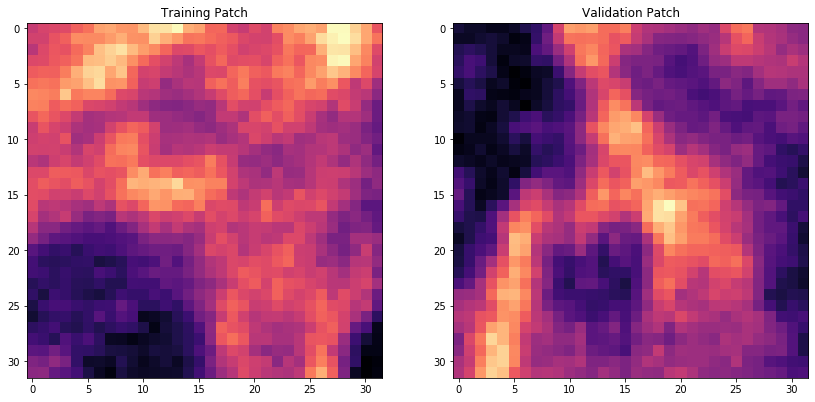

In [0]:
# The code is from the original notebook (https://github.com/juglab/n2v)

#@markdown Play the cell to generate patches from the training image. 

#@markdown * Patches allows to increase the speed of training of network. 

#@markdown * The cell will show one training and validation patch.

# split patches from the training images
Xdata = datagen.generate_patches_from_list(imgs, shape=(size,size))
shape_of_Xdata = Xdata.shape
# create a threshold (10 % patches for the validation)
threshold = int(shape_of_Xdata[0]/10)
# split the patches into training patches and validation patches
X = Xdata[threshold:]
X_val = Xdata[:threshold]
%memit 

# creates a plot and shows one training patch and one validation patch.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='magma')
plt.title('Validation Patch');

### **4.3 Setup the model**

In [0]:
# The code is from the original notebook (https://github.com/juglab/n2v)

#@markdown Play the cell to input parameters (from section 3.1) into training model.

# create a Config object
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=steps,train_epochs=epochs, train_loss='mse', batch_norm=True, 
                   train_batch_size=number, n2v_perc_pix=1.6, n2v_patch_shape=(size, size), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

# a name the model
model_name = my_model                                  
# the base directory for your model
basedir = path_model             
# create network model.
model = N2V(config, model_name, basedir=basedir)

print("Setup done.")

/usr/local/lib/python3.6/dist-packages/n2v/models/n2v_standard.py:409: UserWarning: output path for model already exists, files may be overwritten: /content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Filopodia_widefield_dataset_low/results/N2V_Filopodia_low3_JJ
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))















Setup done.


### **4.4 Train the model**

In this section we start the training of network.

You see results for every epoch (round). You can estimate the training time by following equation: t(training) = ( t(s)/epoch x epochs)/60. For example: 

t(training) = (16 s/epoch x 400 epochs)/60 = 106,7 min

**CRITICAL NOTE: Google Colab has time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours!** If training takes longer than 12 hours, please decrease the training parameters or training data.

In [0]:
#@markdown Play the cell to start network training.
%memit
# The code is from the original notebook (https://github.com/juglab/n2v)
# Play the cell to start training the network.
history = model.train(X, X_val)
print("Training done.")
%memit

peak memory: 1100.96 MiB, increment: 0.11 MiB



Preparing validation data:   0%|          | 0/360 [00:00<?, ?it/s]

16 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 360/360 [00:00<00:00, 1366.33it/s]




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/400
100/100 [==============================] - 42s 419ms/step - loss: 0.1045 - n2v_mse: 0.1045 - n2v_abs: 0.1661 - val_loss: 0.0142 - val_n2v_mse: 0.0142 - val_n2v_abs: 0.0929

Epoch 2/400
100/100 [==============================] - 33s 328ms/step - loss: 0.0283 - n2v_mse: 0.0283 - n2v_abs: 0.0952 - val_loss: 0.0077 - val_n2v_mse: 0.0077 - val_n2v_abs: 0.0667
Epoch 3/400
100/100 [==============================] - 34s 337ms/step - loss: 0.0201 - n2v_mse: 0.0201 - n2v_abs: 0.0849 - val_loss: 0.0071 - val_n2v_mse: 0.0071 - val_n2v_abs: 0.0662
Epoch 4/400
100/100 [==============================] - 34s 336ms/step - loss: 

### **4.5 Estimate the training**

Here we look at the resulting image


100%|██████████| 2/2 [00:00<00:00, 90.29it/s]


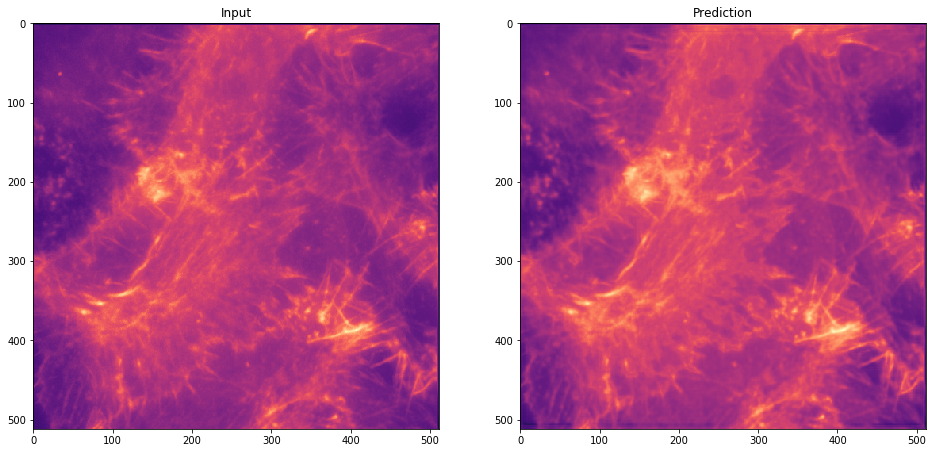

In [0]:
#@title Default title text
# We load the data we want to process.
input_train = imgs[0][0,...,0]
# Here we process the data.
# The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
pred_train = model.predict(input_train, axes='YX', n_tiles=(2,1))

# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(input_train[:1500:,:1500],cmap="magma")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred_train[:1500,:1500],cmap="magma")
plt.title('Prediction');

Here we estimate our training. 

**Loss error** <code>(loss)</code> descripes the error in each epoch when network process the training images.

**Validation error** <code>(val_loss)</code> descripes the error in each epoch when network process the validations images.

Both error values in the beginning of training are remarkebly higher and decrease during the training. Rule of thump is that validation loss error <code>(val_loss)</code> is slightly higher than training error <code>(loss)</code> in the latest epochs. 

If **validation error is clearly higher than training error**, it means that training data is too complicated or unrelevant and the network fails validation significally. For example like in situation where students study animal species but exam requires only knowledge of plant species. Trained network fails to improve unseen images.

If **validation error is clearly smaller than training error**, it means that training data is too simple and the network pass validation too easily. For example like in situation where student study dogs breeds but exam requires knowledge of all domesticated species. Networks fails to improve unseen images.

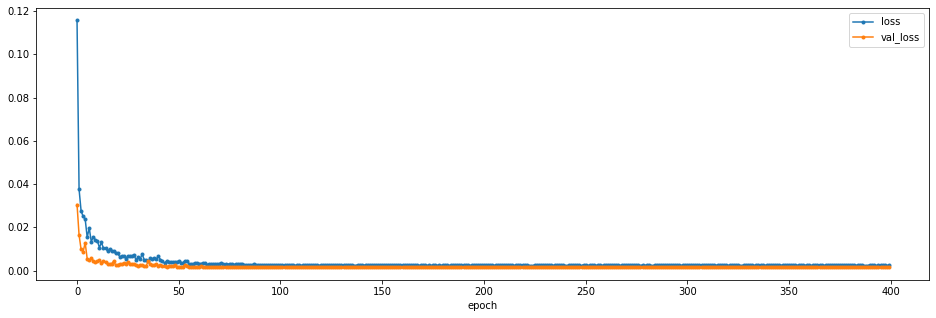

In [0]:
#@markdown Play the cell show figure of training errors

#@title Play the cell to show figure of training results
# The code is from the original notebook (https://github.com/juglab/n2v)
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# The figure is saved into content/ as test.csv (refresh the Files if needed). 
RESULTS = results+'/test.csv'
with open(RESULTS, 'w') as f:
    for key in hist_df.keys():
        f.write("%s,%s\n"%(key,hist_df[key]))

### **4.6 Export Model to be Used with CSBDeep Fiji Plugins and KNIME Workflows (optional)**
See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [0]:
#@markdown Play the cell to export the model.
# The code is from the original notebook (https://github.com/juglab/n2v)
model.export_TF()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmpeuopzdgc/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Filopodia_widefield_dataset_low/results/N2V_Filopodia_low3/TF_SavedModel.zip


# **5. Prediction**

This part allow to batch process images using the model (generated or pretrained).


### 5.1 Activating the pretrained network

In [0]:
#@markdown Play the cell to activate pretrained model.

#@markdown * If you have trained network in section 4, DO NOT run this cell. Doing so will crash the notebook.

# The code is from the original notebook (https://github.com/juglab/n2v)
# a name the model
model_name = my_model                                  
# the base directory for your model
basedir = path_model             
# create network model as pretrained model.
config = None
model = N2V(config, model_name, basedir=basedir)

print("Setup done.")

Loading network weights from 'weights_best.h5'.
Setup done.


### 5.2. Prediction of images

In [0]:
#@markdown Play the cell to predict your images. The results are saved into your Results-folder. 

print("Saving the images...")
thisdir = Path(test_data)
outputdir = Path(results)

# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
        if ".tif" in file:
            print(os.path.join(r, file))

# The code by Lucas von Chamier.
for r, d, f in os.walk(thisdir):
  for file in f:
    base_filename = os.path.basename(file)
    input_train = imread(os.path.join(r, file))
    pred_train = model.predict(input_train, axes='YX', n_tiles=(2,1))
    save_tiff_imagej_compatible(os.path.join(outputdir, base_filename), pred_train, axes='YX')         
print("Completed.")

Saving the images...
/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Filopodia_widefield_dataset_low/prediction/1070319_SI60x_actin_06_visit_11_WF_ALX.dv - C=1.tif
/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Filopodia_widefield_dataset_low/prediction/1070319_SI60x_actin_06_visit_17_WF_ALX.dv - C=1.tif
/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Filopodia_widefield_dataset_low/prediction/1070319_SI60x_actin_06_visit_9_WF_ALX.dv - C=1.tif
/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Filopodia_widefield_dataset_low/prediction/1070319_SI60x_actin_06_visit_5_WF_ALX.dv - C=1.tif
/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 2D/Filopodia_widefield_dataset_low/prediction/1070319_SI60x_actin_06_visit_8_WF_ALX.dv - C=1.tif
/c

100%|██████████| 2/2 [00:00<00:00, 63.03it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 61.97it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 62.19it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 56.51it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 63.41it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 66.62it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 55.12it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 59.81it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 61.47it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 56.95it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 58.95it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 65.50it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 59.65it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 64.69it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 66.93it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 57.94it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 61.08it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 43.97it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 54.89it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 56.64it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 74.33it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 52.31it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 55.05it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 66.73it/s]

The input image is of type uint16 and will be casted to float32 for prediction.



100%|██████████| 2/2 [00:00<00:00, 51.23it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


Completed.


# **6. Store your results**

---
**Copy your data** and ALL its results elsewhere and after that clean the original folder tree (datasets, results, trained_model etc) if you plan to train or use new networks. Please note that notebook will **OVERWRITE** all files which have the same name.

Thank you for using this notebook!
